In [1]:
import cv2


from matplotlib import pyplot as plt

# This opens an inteactive figure - use it in part B
import matplotlib
matplotlib.use('TkAgg')

import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import null_space

# This specifies the way plots behave in jupyter notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'


import platform
print("Python version: ", platform.python_version())
print("Numpy version: ", np.__version__)

Python version:  3.11.5
Numpy version:  1.24.2




## <span style="color:blue">Detect a Straight Lines

In this part you will use the set of edge points to detect straight lines in an image.\
The input will consist of edge points computed by the Canny edge detector - you can use the implementation of CV2, which is demonstrated below.\
    The output will be a set of straight lines in the image. There are two main methods to compute straight lines from such input: the Hough transform and RANSAC. You will implement the Hough transform.

    

**Hough transform**\
Every 2D line, $\ell$,   can be represented by 2 parameters:  $r$ and $\theta$ where all points on the lines satisfy $r=(xcos\theta, ysin\theta)$. 
Let $P_0=(x_0,y_0)$ be the intersection of a normal to $\ell$ from the origin.
The distance between $P_0$ and the origin is given by $r$ and the angle between the normal and the $x$ axis is given by $\theta$. 






**Your goal:**     Write the following function\
Straight_lines(image_file, res_r, res_orient,min_number_points,display,  ...)\
    You can add any other parameters that you need.
    


 To do so, you need also to define the following functions. 
 You can add parameters to the functions, as long as you  provide clear explanations of their roles and purposes.

In [2]:
# Input: a set of edge points (or corners), and the resolution of the distance and angles. 
# output: the Hough matrix (H) containing votes for lines represented by r and θ.

def  H_matrix(L_points, resolution_r, resolution_ang):
    #calculate theta and r ranges
    img_diag_len = int(np.sqrt(L_points.shape[0]**2 + L_points.shape[1]**2))
    tested_angles = np.deg2rad(np.arange(0, 180, resolution_ang))
    rs = np.arange(-img_diag_len, img_diag_len +resolution_r, resolution_r)
    
    H = np.zeros((len(rs), len(tested_angles)), dtype=np.uint)
    y, x = np.nonzero(L_points)

    # for every edge we calculat r value for every possible theta that cross the edge
    # for every theta and r we add 1 in H martix in index [r,theta]
    # if there is a straight line the calue in H[r,theta] will be grater than 1
    for i in range(len(x)):
        for theta in tested_angles:
            r_val = int(x[i] * np.cos(theta) + y[i] * np.sin(theta))
            r_index = r_val // resolution_r
            theta_index = int(np.degrees(theta) / resolution_ang)
            H[r_index, theta_index] += 1        
    return H

# Input: The Hough matrix $H$, and a threshold for the number of minimal points on the line.
# output a list of triplets:  $(r, \Theta, num_points)$ where
# num_points is the number of points on that line.

def  list_lines(H,th, resolution_r, resolution_ang):
# th - number of minimal points on the line   
    indices = np.where(H >= th)

    r_indices, theta_indices = indices
    num_points = H[indices]
    #translate indeces in H to real values again
    rs = r_indices * resolution_r
    thetas = np.deg2rad(theta_indices * resolution_ang)
    lines = list(zip(rs, thetas, num_points))
    return lines

# Display the detected lines in red - overlaid the original image
# Note: one way to do is, is to add the red lines to the image, and then display it
def display_lines(im,list_lines):
    imC = np.dstack([im,im,im])   # a gray level image that is saved as a color image
    for line in list_lines:
        r, theta, _ = line
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)
        x = r * cos_theta
        y = r * sin_theta
        x1 = (x + 1000*sin_theta).astype(int)
        y1 = (y - 1000*cos_theta).astype(int)
        x2 = (x - 1000*sin_theta).astype(int)
        y2 = (y + 1000*cos_theta).astype(int)
        cv2.line(imC, (x1, y1), (x2, y2), (255,0,0), thickness=1)

    plt.rcParams['figure.figsize'] = (16.0, 16.0) 
    f, ((ax1, ax2)) = plt.subplots(1, 2, sharex='col', sharey='row')

    ax1.imshow(im), ax1.set_title('Original Image')
    ax2.imshow(imC), ax2.set_title('Image With straght lines')


In [5]:
#Now use the above functions to implement 
def straight_lines(image_file, res_r, res_orient, min_number_points,display=True):
    im = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(im,250,500,5)
    H = H_matrix(edges, res_r, res_orient)
    detected_lines = list_lines(H, min_number_points, res_r, res_orient)
    if display:
        display_lines(im, detected_lines)

    return len(detected_lines)



24

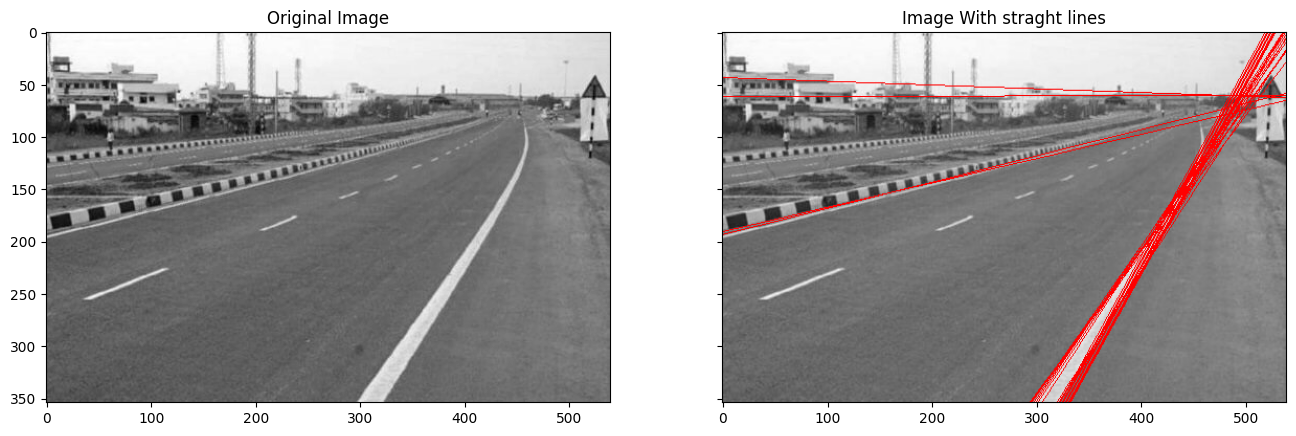

In [6]:
image_path = 'images/linesOnTheRoadGray.jpg'
resolution_r = 1
resolution_orient = 1
min_points = 80
straight_lines(image_path, resolution_r, resolution_orient, min_points, display=True)

(<matplotlib.image.AxesImage at 0x25be63e0ad0>, Text(0.5, 1.0, 'Edge Image'))

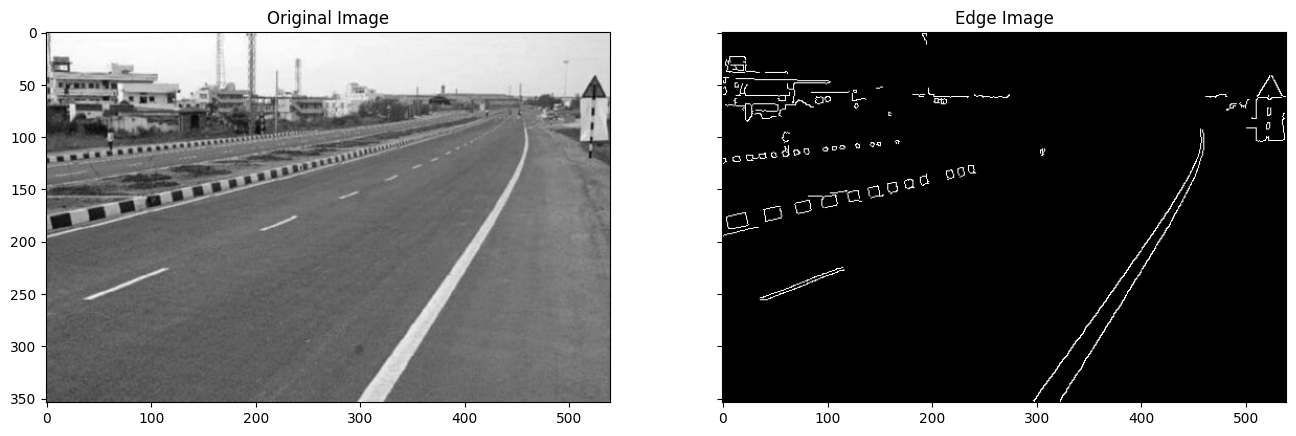

In [7]:
# Here is an example of how to use the CV2 Canny edge detector.
# You can play with the parameters to achieve desired results.
# Note that this implementation does not include smoothing with a Gaussian filter :(


img = cv2.imread('images/linesOnTheRoadGray.jpg', cv2.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"

edges = cv2.Canny(img,250,500,5)

plt.rcParams['figure.figsize'] = (16.0, 16.0) 
f, ((ax1, ax2)) = plt.subplots(1, 2, sharex='col', sharey='row')

ax1.imshow(img), ax1.set_title('Original Image')
ax2.imshow(edges), ax2.set_title('Edge Image')


Generate a synthetic image to test your Hough Transform algorithm. 

In [8]:
def draw_star_of_david(image, center, size):
    # Define the points for two triangles
    pts_up = np.array([
        (center[0], center[1] - size),
        (center[0] - size * np.sin(np.pi / 3), center[1] + size * np.cos(np.pi / 3)),
        (center[0] + size * np.sin(np.pi / 3), center[1] + size * np.cos(np.pi / 3))
    ], np.int32)
    pts_down = np.array([
        (center[0], center[1] + size),
        (center[0] - size * np.sin(np.pi / 3), center[1] - size * np.cos(np.pi / 3)),
        (center[0] + size * np.sin(np.pi / 3), center[1] - size * np.cos(np.pi / 3))
    ], np.int32)

    # Draw the triangles
    cv2.polylines(image, [pts_up.reshape((-1, 1, 2))], isClosed=True, color=(100), thickness=10)
    cv2.polylines(image, [pts_down.reshape((-1, 1, 2))], isClosed=True, color=(230), thickness=10)


def create_geometric_shapes_image(size):
    image = np.ones((size, size), dtype=np.uint8) * 255

    # Draw a square
    cv2.rectangle(image, (120, 120), (270, 270), 150, -1)

    # Draw lines
    cv2.line(image, (50, 200), (150, 350), 200, 15)
    cv2.line(image, (150, 230), (50, 350), 100, 15)

    # Draw Star of David
    draw_star_of_david(image, (280, 275), 70)

    return image

# Create a synthetic image with geometric shapes
shapes_image = create_geometric_shapes_image(400)
cv2.imwrite('images/syntetic_image.jpg', shapes_image)



True

12

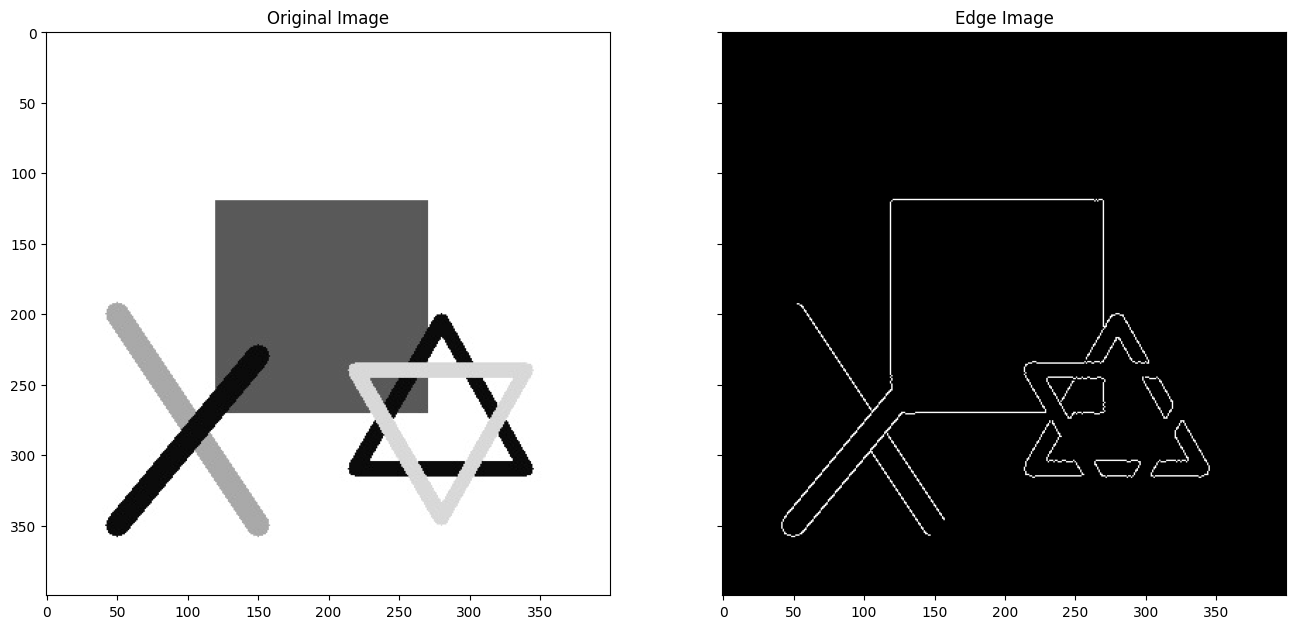

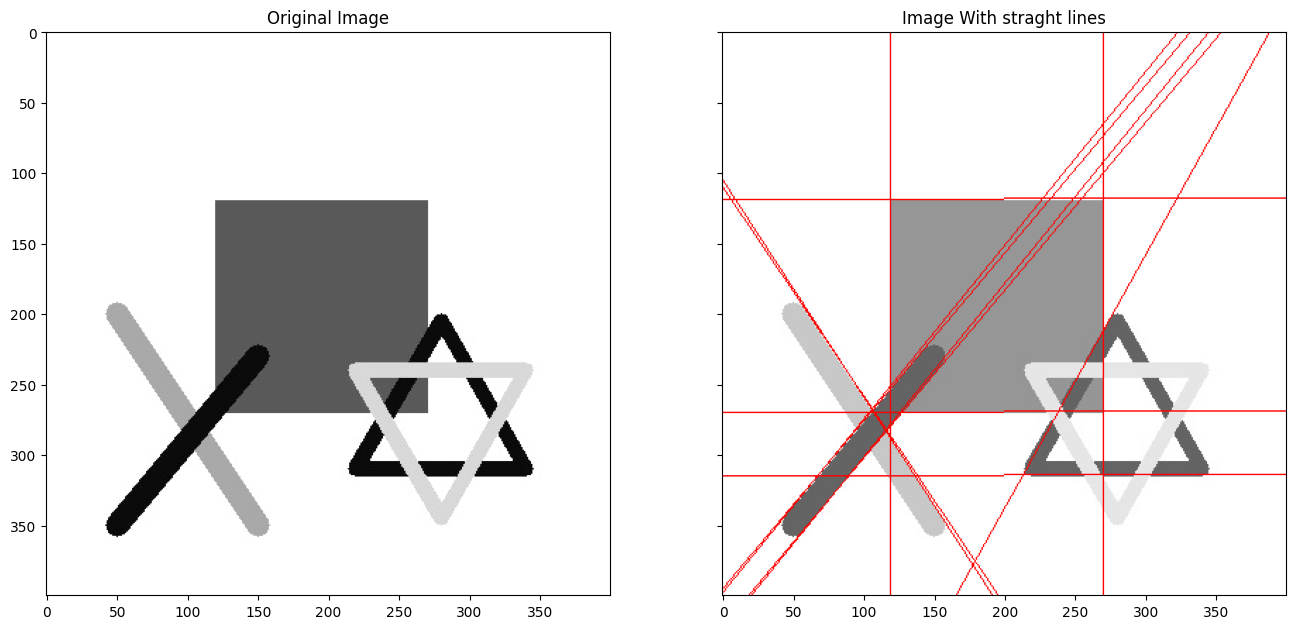

In [9]:
img = cv2.imread('images/syntetic_image.jpg', cv2.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"
edges = cv2.Canny(img,250,500,5)
plt.rcParams['figure.figsize'] = (16.0, 16.0) 
f, ((ax1, ax2)) = plt.subplots(1, 2, sharex='col', sharey='row')
ax1.imshow(img), ax1.set_title('Original Image')
ax2.imshow(edges), ax2.set_title('Edge Image')

#Apply straght lines detection
image_path = 'images/syntetic_image.jpg'
resolution_r = 1
resolution_orient = 1
min_points = 75
straight_lines(image_path, resolution_r, resolution_orient, min_points)

40

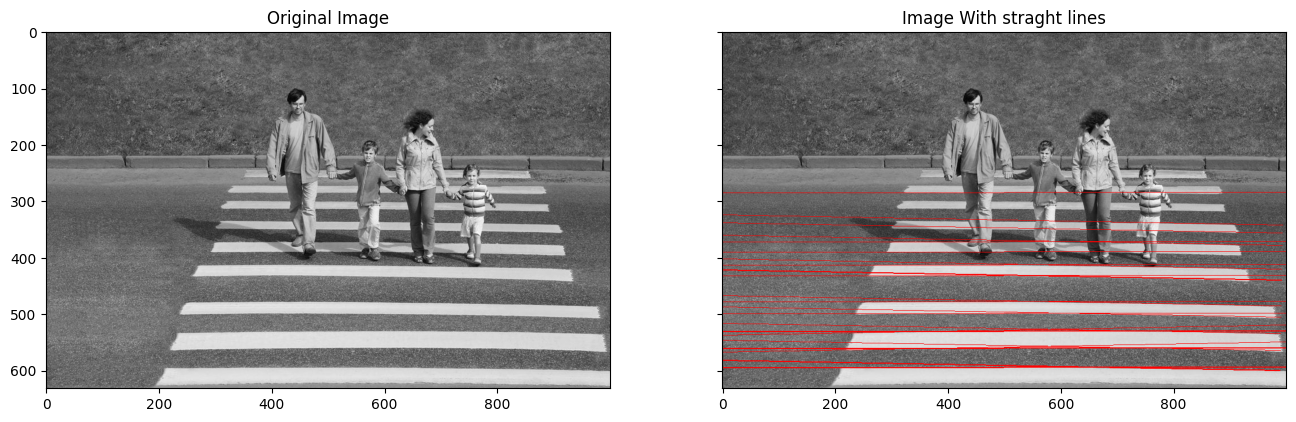

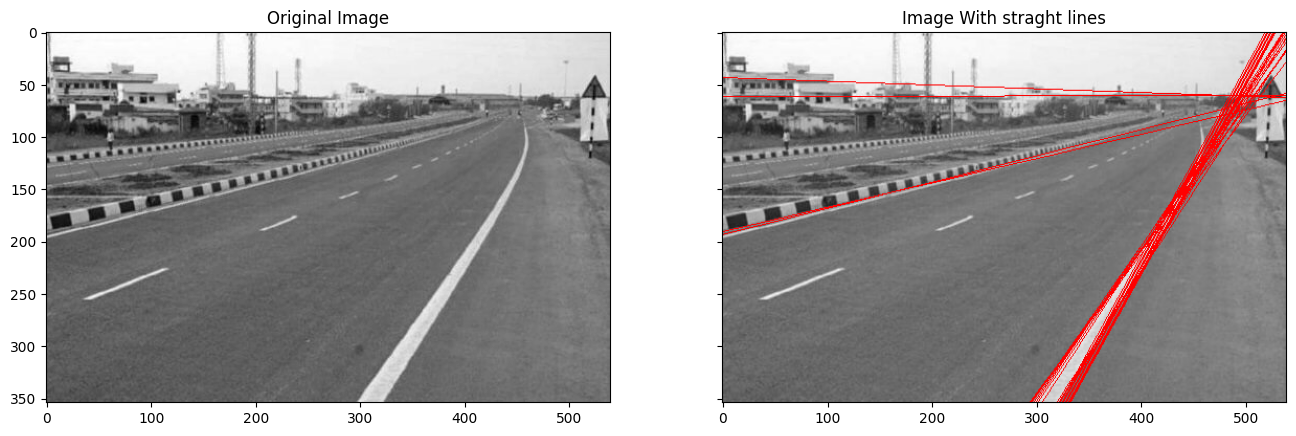

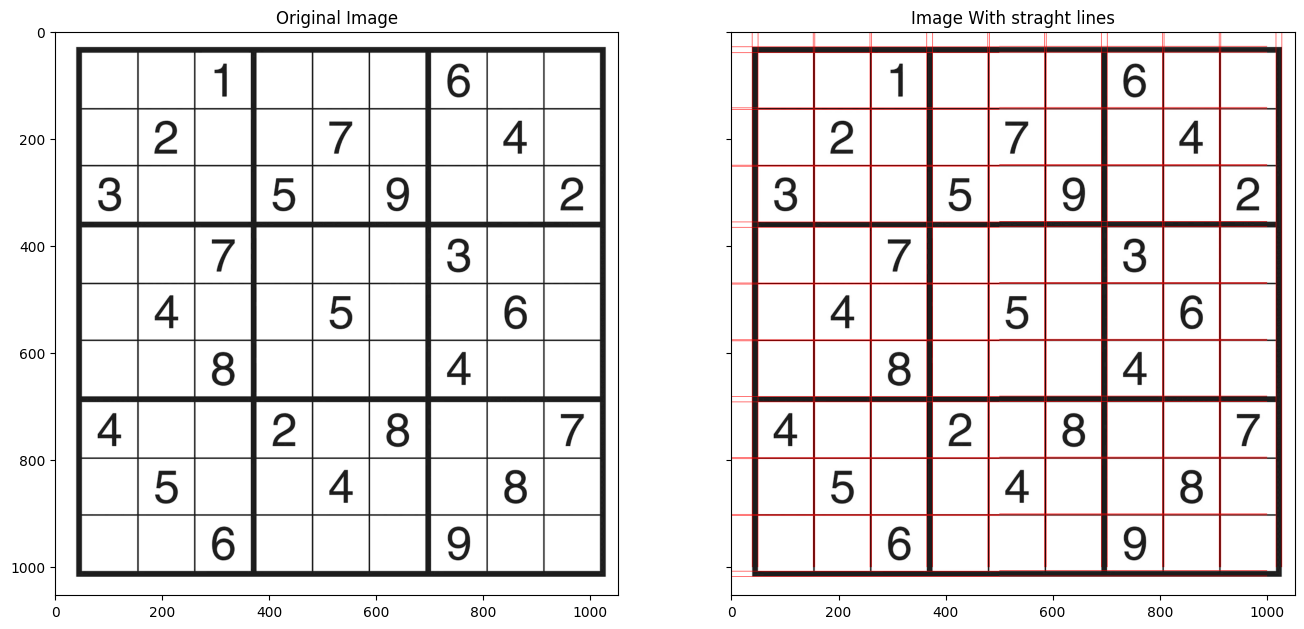

In [10]:
# Question 2
#Apply your algorithm to the following images: Crosswalk, linesOnTheRoadGray, Sudoku. 
#   * Choose a set of parameters so the results looks fine.
#   * You may need different parameters for each image.
#   * Display the results.

path_1 = 'images/Crosswalk.jpg'
path_2 = 'images/linesOnTheRoadGray.jpg'
path_3 = 'images/Sudoku.PNG'

image_path = 'images/linesOnTheRoadGray.jpg'
resolution_r = 1
resolution_orient = 1

min_points_1 = 150
min_points_2 = 80
min_points_3 = 500

straight_lines(path_1, resolution_r, resolution_orient, min_points_1, display=True)
straight_lines(path_2, resolution_r, resolution_orient, min_points_2, display=True)
straight_lines(path_3, resolution_r, resolution_orient, min_points_3, display=True)

**Question 3**

   **High resolution** in the accumulator array (Hough matrix), allowing for more accurate detection of lines with different orientations and more accurate detection of lines with different distances from the origin. This also can couse more noises and detect more wrong lines. However, increasing the resolution also increases the computational cost, as it requires mor iterations. 

   **low resolutions** can lead to fewer bins in the accumulator array. This might result in fewer distinguishable lines and reduced accuracy. In terms of $\theta$ it can also reduced accuracy in detecting lines with different orientations. 



9

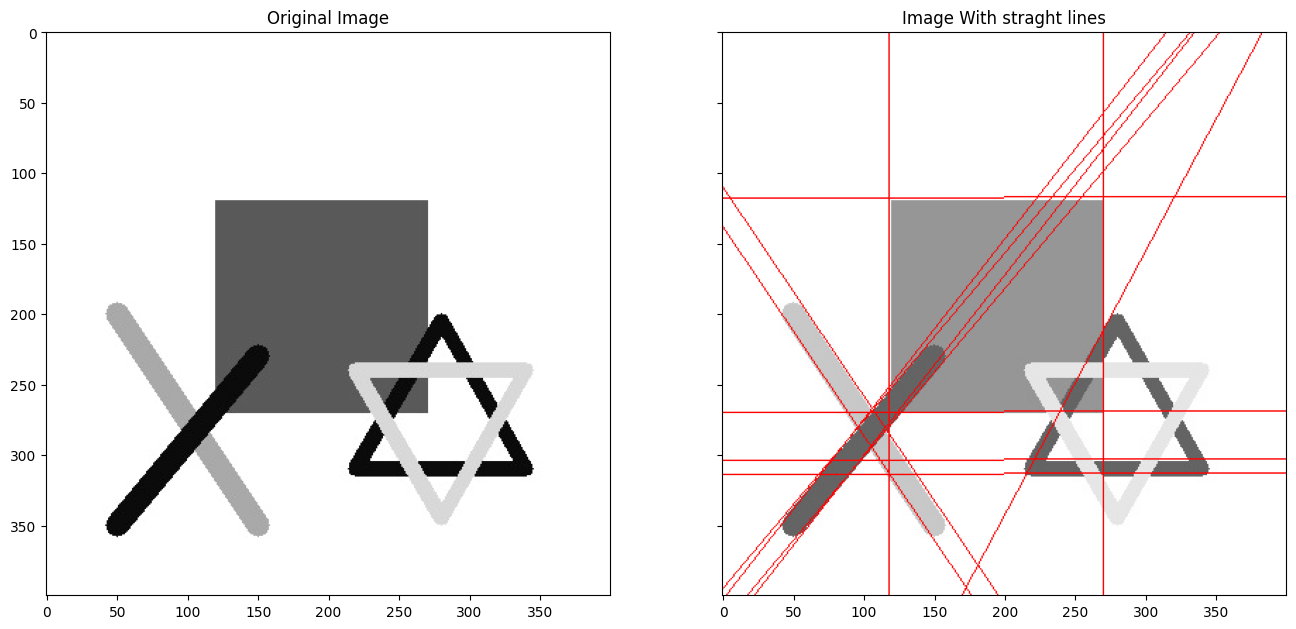

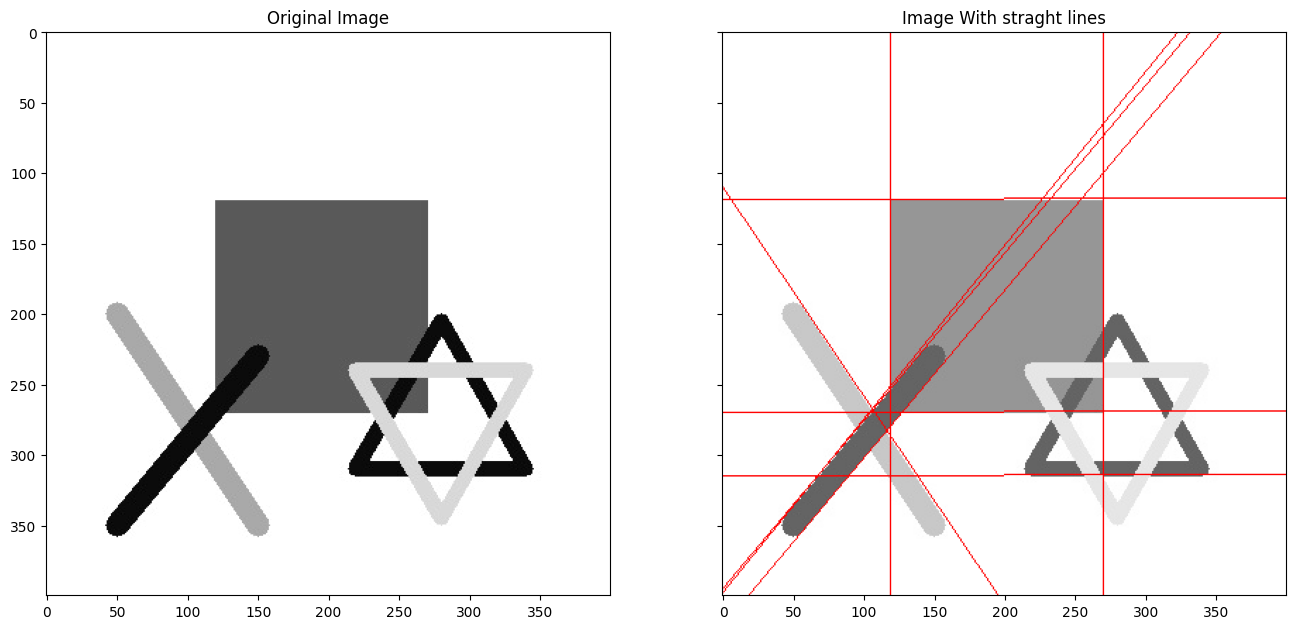

In [11]:
image_path = 'images/syntetic_image.jpg'
resolution_r = 2
resolution_orient = 2
min_points = 80
straight_lines(image_path, resolution_r, resolution_orient, min_points, display=True)

resolution_r = 1
resolution_orient = 1
min_points = 80
straight_lines(image_path, resolution_r, resolution_orient, min_points, display=True)